In [1]:
import pandas as pd
from IPython.display import display, HTML

pd.options.display.max_rows = None
pd.options.display.max_columns = None

df=pd.read_csv('cohort_final.csv') # filename renamed from 'final_table_v1.1.csv' to avoid confusion

# df.head(37)
# df.columns

# df.shape, df.dtypes

In [2]:
# check for missing values to remove rows (patients) with missing data
missing_value=df.isnull()
total=missing_value.sum()
# print(total)
df.shape

(18028, 86)

In [3]:
# drop rows with missing values in these columns
df_dropped_rows = df.loc[
    ~df.po2.isna() & ~df.pco2.isna() & ~df.ph.isna() & ~df.baseexcess.isna() & ~df.weight.isna()
    & ~df.heart_rate_min.isna() & ~df.sbp_min.isna() & ~df.mbp_min.isna() & ~df.resp_rate_min.isna()
    & ~df.spo2_min.isna() & ~df.glucose_min.isna() & ~df.bun_min.isna() & ~df.creatinine_min.isna()
    & ~df.sodium_min.isna() & ~df.potassium_min.isna() & ~df.gcs_min.isna() & ~df.temperature_min.isna()]

# # cannot drop rows with missing values for the following
# df = df[~df.lactate.isna()]
# df = df[~df.bilirubin_total_min.isna()]

missing_value=df_dropped_rows.isnull()
total=missing_value.sum()
# print(total)
# df_dropped_rows.shape

In [4]:
df_dropped_cols = df_dropped_rows.drop(columns = ['lactate','bilirubin_total_min','bilirubin_total_max'])
# rename df
df = df_dropped_cols
df.shape

(14147, 83)

In [5]:
# primary outcome: 28 days mortality; 
# "OHE": 1 = passed away within 28d, 0 = survived beyond 28days, or did not pass away while in hospital
df['days_interval_mortality']=df['days_interval_mortality'].fillna(0)
df['28_mortality']=0
df.loc[(df['days_interval_mortality']<=28)&(df['days_interval_mortality']>0),'28_mortality']=1
df['28_mortality']=df['28_mortality']*df['hospital_expire_flag']

# secondary outcome: 28d icu-free day
df['28_icufreeday']=(df['28_mortality']-1)*df['icu_freeday28']*(-1)
df['28_icufreeday']=df['28_icufreeday'].apply(lambda x:max(0,x))

# secondary outcome: 28d mv-free day
df['days28_mvfree']=df['days28_mvfree'].fillna(28)
df['28_mvfreeday']=df['days28_mvfree'].apply(lambda x:max(0,x))
# df.head(37)

# "OHE" treatment group: 1 = exposed group; 0 = control group
df['treatment']=1
df['treatment']=df['steroid_first_dose_time'].apply(lambda x:0 if pd.isna(x) else 1)

# check shape
df.shape

(14147, 87)

In [6]:
# drop columns that are no longer needed in the analysis
# retain the covariates 

df_dropped = df.drop(columns=['subject_id','hadm_id', 'dod', 'admittime',
       'dischtime', 'los_hospital', 'hospital_expire_flag', 'hospstay_seq', 'first_hosp_stay', 'icu_intime',
       'icu_outtime', 'los_icu', 'icustay_seq', 'first_icu_stay',
       'antibiotic_time', 'culture_time', 
       'sofa_time','days_interval_mortality',
       'steroid_first_dose_time', 'suspected_infection_time','sepsis3',
       'icu_freeday28', 'days28_mvfree'])

df_dropped.shape

(14147, 64)

In [7]:
# # save final cohort table as csv
# df_dropped.to_csv('cohort_final.csv', index = False)

# OHE categorical covariates
df_encoded = pd.get_dummies(df_dropped, columns = ['gender', 'race'])

# save ONE-ed to csv for statistical analysis using R
df_encoded.to_csv("cohort_final_dummies.csv", index = False)

In [8]:
# assign treatment, covariates, and outcome columns
treatment_col = 'treatment'
covariate_cols = ['admission_age', 'sofa_score', 'respiration', 'coagulation',
       'liver', 'cardiovascular', 'cns', 'renal', 'weight',
       'congestive_heart_failure', 'cerebrovascular_disease',
       'chronic_pulmonary_disease', 'rheumatic_disease', 'renal_disease',
       'malignant_cancer', 'severe_liver_disease',
       'charlson_comorbidity_index', 'heart_rate_min', 'heart_rate_max',
       'heart_rate_mean', 'sbp_min', 'sbp_max', 'sbp_mean', 'dbp_max',
       'dbp_min', 'dbp_mean', 'mbp_max', 'mbp_min', 'mbp_mean',
       'resp_rate_min', 'resp_rate_max', 'resp_rate_mean', 'temperature_min',
       'temperature_max', 'temperature_mean', 'spo2_min', 'spo2_max',
       'spo2_mean', 'glucose_min', 'glucose_max', 'glucose_mean', 'po2',
       'pco2', 'ph', 'baseexcess', 'bun_min', 'bun_max', 'creatinine_min',
       'creatinine_max', 'sodium_min', 'sodium_max', 'potassium_min',
       'potassium_max', 'gcs_min', 'oasis', 'oasis_prob', 'ventilation',
       'gender_F', 'gender_M', 'race_AMERICAN INDIAN/ALASKA NATIVE',
       'race_ASIAN', 'race_ASIAN - ASIAN INDIAN', 'race_ASIAN - CHINESE',
       'race_ASIAN - KOREAN', 'race_ASIAN - SOUTH EAST ASIAN',
       'race_BLACK/AFRICAN', 'race_BLACK/AFRICAN AMERICAN',
       'race_BLACK/CAPE VERDEAN', 'race_BLACK/CARIBBEAN ISLAND',
       'race_HISPANIC OR LATINO', 'race_HISPANIC/LATINO - CENTRAL AMERICAN',
       'race_HISPANIC/LATINO - COLUMBIAN', 'race_HISPANIC/LATINO - CUBAN',
       'race_HISPANIC/LATINO - DOMINICAN', 'race_HISPANIC/LATINO - GUATEMALAN',
       'race_HISPANIC/LATINO - HONDURAN', 'race_HISPANIC/LATINO - MEXICAN',
       'race_HISPANIC/LATINO - PUERTO RICAN',
       'race_HISPANIC/LATINO - SALVADORAN', 'race_MULTIPLE RACE/ETHNICITY',
       'race_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'race_OTHER',
       'race_PATIENT DECLINED TO ANSWER', 'race_PORTUGUESE',
       'race_SOUTH AMERICAN', 'race_UNABLE TO OBTAIN', 'race_UNKNOWN',
       'race_WHITE', 'race_WHITE - BRAZILIAN', 'race_WHITE - EASTERN EUROPEAN',
       'race_WHITE - OTHER EUROPEAN', 'race_WHITE - RUSSIAN']
outcome_col = '28_mortality'

df_encoded = df_encoded[~df_encoded.weight.isna()]
missing_value=df_encoded.isnull()
total=missing_value.sum()
# print(total)
df.shape

(14147, 87)

#### Perform gbm fit to assess importance of covariates

In [9]:
# perform fit with train-test-split to evaluate "goodness" of fit

from sklearn.ensemble import GradientBoostingClassifier as gbm
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_encoded[covariate_cols], 
                                                    df_encoded[treatment_col], test_size=0.2)

ps_model = gbm()
ps_model.fit(X_train, y_train)
ps_score = ps_model.predict_proba(X_test)[:,1]

              precision    recall  f1-score   support

           n       0.81      0.96      0.88      2200
           y       0.62      0.20      0.30       630

    accuracy                           0.79      2830
   macro avg       0.71      0.58      0.59      2830
weighted avg       0.77      0.79      0.75      2830

AUC-ROC: 0.76


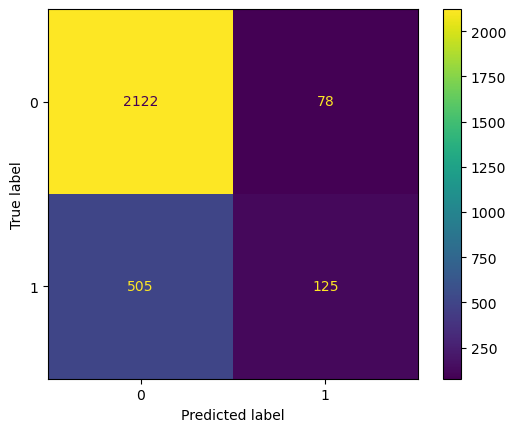

In [10]:
# import libraries to evaluate models
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score 
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score

y_pred = ps_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
auc_roc = roc_auc_score(y_test, ps_model.predict_proba(X_test)[:, 1])


# print(f"Accuracy: {accuracy}")
# print(f"Confusion matrix:")
disp = ConfusionMatrixDisplay(confusion_matrix=confusion)
disp.plot()
print(classification_report(y_test, y_pred, target_names=['n','y']))
print('AUC-ROC:', f'{auc_roc:.2f}')

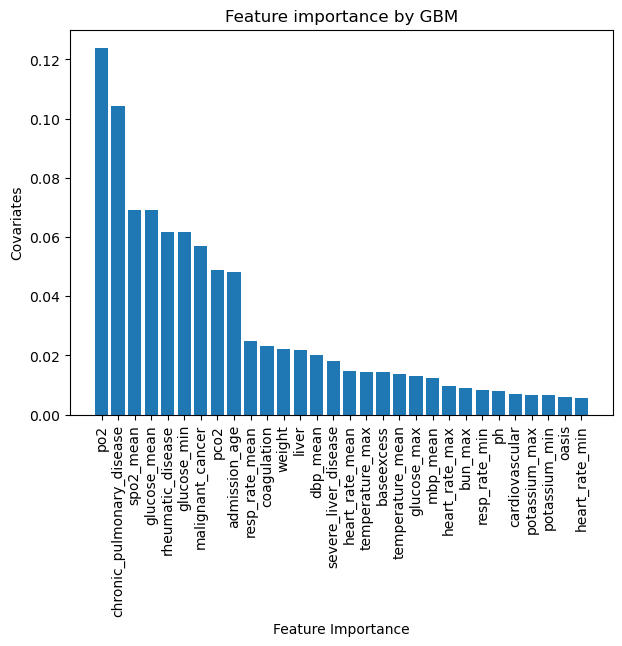

In [11]:
### plot importance against covariates

import numpy as np
import matplotlib.pyplot as plt

# creating the dataset
ls_importances_ = (ps_model.feature_importances_).tolist()
ls_colnames = list(covariate_cols)

# # Sort feature importances and feature names in ascending order
# sorted_indices = np.argsort(ls_importances_)[::1]
# plt.bar(sorted_colnames[-30:], sorted_importances[-30:])

# Sort feature importances and feature names in descending order
sorted_indices = np.argsort(ls_importances_)[::-1]
sorted_importances = [ls_importances_[i] for i in sorted_indices]
sorted_colnames = [ls_colnames[i] for i in sorted_indices]

# Create the bar plot
fig = plt.figure(figsize=(7, 5))
plt.bar(sorted_colnames[:30], sorted_importances[:30])

 
plt.xlabel("Feature Importance")
plt.xticks(rotation=90)
plt.ylabel("Covariates")
plt.title("Feature importance by GBM")
plt.show()

#### Hyperparameter-tuning of depth did not reveal better models

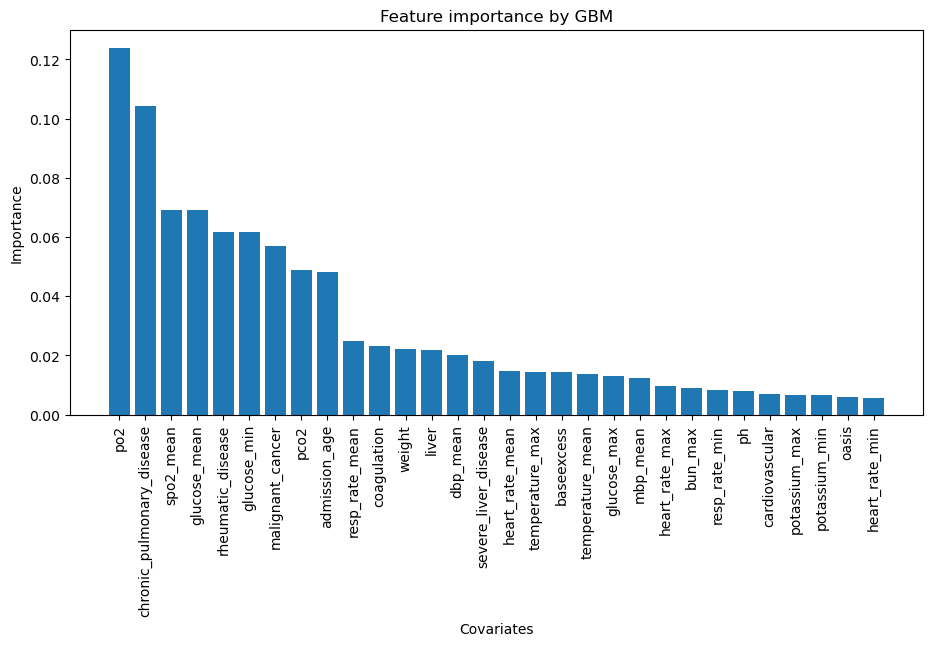

In [12]:
# Create the bar plot
fig = plt.figure(figsize=(11, 5))
plt.bar(sorted_colnames[:30], sorted_importances[:30])

 
plt.xlabel("Covariates")
plt.xticks(rotation=90)
plt.ylabel("Importance")
plt.title("Feature importance by GBM")
plt.show()

In [13]:
def evaluate(model, x_train, x_test, y_train, y_test):

    # function takes the regressor, x_train, and y_train, train model
    model.fit(X=x_train,y=y_train)
    # define variables to hold the predicted values
    y_hat_train = model.predict(x_train)
    y_hat_test = model.predict(x_test)
    
    # Evaluate and print metrics
    metrics = [f'{precision_score(y_test, y_hat_test):.2f}', 
               f'{recall_score(y_test, y_hat_test):.2f}',
               f'{f1_score(y_test, y_hat_test):.2f}',
               f'{accuracy_score(y_test, y_hat_test):.2f}',
               f'{roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]):.2f}']
    
    return metrics

6.29 min


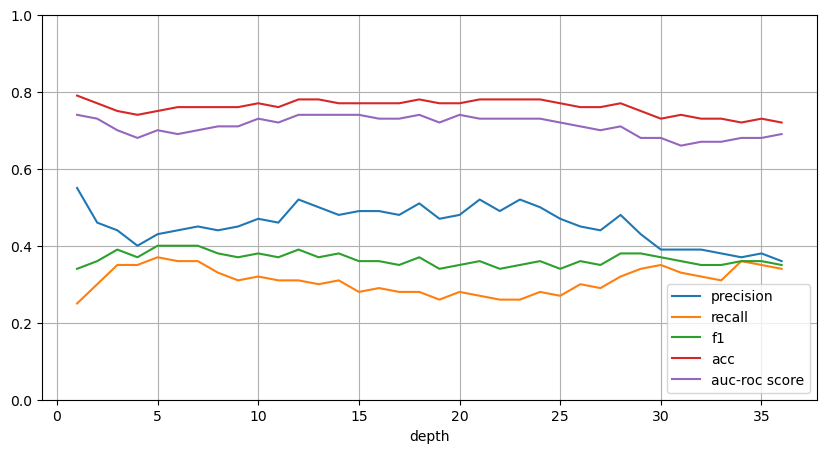

In [14]:
# Attepmt to tune hyperparameter "depth"

from sklearn.ensemble import GradientBoostingClassifier
import time

n = 37 # n = max depth
ls = []
start_time = time.time()
for depth in range(1,n):
    model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=depth, random_state=73)
    ls.append(evaluate(model=model,
                       x_train = X_train, x_test = X_test,
                       y_train = y_train, y_test = y_test))

print(f'{((time.time()-start_time)/60):.2f}','min')

df = pd.DataFrame(ls, columns = ['precision','recall','f1','acc', 'auc-roc score'])
df.insert(0,'depth', list(range(1,n)))    

# df elements at this point are objects; need to convert to float to be plotted
df = df.astype(float)

import matplotlib.pyplot as plt
ax = df.plot.line(x='depth', y=['precision','recall','f1','acc', 'auc-roc score'],
             figsize=(10, 5), grid=True)
ax.set_ylim(0,1)
plt.show()

#### Perform corhort matching using propensity scoring using knn

In [15]:
# perform propensity scoring

from sklearn.neighbors import NearestNeighbors

# perform matching
df_encoded['ps'] = ps_model.predict_proba(df_encoded[covariate_cols])[:, 1]

# assign cohorts
treated = df_encoded[df_encoded[treatment_col] == 1]
control = df_encoded[df_encoded[treatment_col] == 0]

# employ knn to determine "similarity" and matching
knn = NearestNeighbors(n_neighbors=1)
knn.fit(control['ps'].values.reshape(-1, 1))
nearest_indices = knn.kneighbors(treated['ps'].values.reshape(-1, 1), return_distance=False)

# process matching
matched_control_data = control.iloc[nearest_indices.flatten()]
matched_data = pd.concat([treated, matched_control_data])

# check cohorts shape
matched_data[matched_data[treatment_col] == 1].shape, matched_data[matched_data[treatment_col] == 0].shape

# save matched cohort for analysis in R
matched_data.to_csv("final_table_matched.csv") # renamed from "psm_final_table"

In [16]:
# check to make sure the shape of groups in the cohort are the same
matched_data[matched_data[treatment_col] == 1].shape, matched_data[matched_data[treatment_col] == 0].shape

((3174, 98), (3174, 98))

#### Print tables generated from R

In [17]:
import pandas as pd

# Load the tables into pandas dataframes
df_table1_cohort_final = pd.read_csv('table1_cohort_final.csv')
df_table1_cohort_matched = pd.read_csv('table1_cohort_matched.csv')

# rename colnames to join tables
df_table1_cohort_final = df_table1_cohort_final.rename(columns={
    'Unnamed: 0': 'covariate',
    '0': 'non-steroid (final)',
    '1': 'steroid (final)',
    'p': 'p value (final)',
    'SMD': 'SMD (final)'})

df_table1_cohort_matched = df_table1_cohort_matched.rename(columns={
    'Unnamed: 0': 'covariate',
    '0': 'non-steroid (matched)',
    '1': 'steroid (matched)',
    'p': 'p value (matched)',
    'SMD': 'SMD (matched)'})

# Perform a left join on the 'id' column
df_table1_merged = pd.merge(df_table1_cohort_final, df_table1_cohort_matched, on='covariate', how='inner')
df_table1_merged.fillna('-', inplace=True)
df_table1_merged.replace(' \(mean \(SD\)\)', '', regex=True, inplace=True)

# choose only rows (covariates) that were in figure 2, the top 30 covariates based on importance
selected_rows = sorted_colnames[:30]
selected_rows.append('n') # to include the number of patients in the table
df_table1_merged = df_table1_merged[df_table1_merged['covariate'].isin(selected_rows)].reset_index(drop=True)


# Save the merged table to a new CSV file
df_table1_merged.to_csv('table1_merged.csv', index = False)
df_table1_merged

,covariate,non-steroid (final),steroid (final),p value (final),SMD (final),non-steroid (matched),steroid (matched),p value (matched),SMD (matched)
0,n,10973,3174,-,-,3174,3174,-,-
1,admission_age,66.69 (16.06),65.14 (15.81),<0.001,0.097,66.15 (14.97),65.14 (15.81),0.009,0.066
2,coagulation,0.48 (0.76),0.54 (0.94),0.003,0.064,0.53 (0.96),0.54 (0.94),0.905,0.003
3,liver,0.25 (0.73),0.41 (0.98),<0.001,0.187,0.45 (1.02),0.41 (0.98),0.132,0.038
4,cardiovascular,1.13 (1.24),1.25 (1.38),<0.001,0.087,1.28 (1.40),1.25 (1.38),0.312,0.025
5,weight,83.59 (25.00),82.86 (25.31),0.150,0.029,83.58 (26.78),82.86 (25.31),0.271,0.028
6,chronic_pulmonary_disease,0.24 (0.42),0.41 (0.49),<0.001,0.388,0.47 (0.50),0.41 (0.49),<0.001,0.116
7,rheumatic_disease,0.02 (0.14),0.08 (0.27),<0.001,0.260,0.08 (0.28),0.08 (0.27),0.230,0.03
8,malignant_cancer,0.11 (0.31),0.22 (0.41),<0.001,0.301,0.26 (0.44),0.22 (0.41),<0.001,0.102
9,severe_liver_disease,0.06 (0.25),0.11 (0.32),<0.001,0.174,0.11 (0.32),0.11 (0.32),0.968,0.001
